In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras import Model, optimizers
from tensorflow.keras.optimizers import RMSprop

In [33]:
## Prepare Dataset
# a. Config
dir_path = './dataset'
batch_size = 32
img_width = 150
img_height = 150

# b. init image data generator
_train_IDG = ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                validation_split=0.1,
                                rescale=1./255,
                                shear_range = 0.1,
                                zoom_range = 0.1,
                                width_shift_range = 0.1,
                                height_shift_range = 0.1,)
_test_IDG = ImageDataGenerator(rescale=1/255,
                               validation_split=0.1)
# c. Apply
train_data_gen = _train_IDG.flow_from_directory(dir_path,
                                                 target_size=(img_width,img_height),
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 subset='training')
test_data_gen = _test_IDG.flow_from_directory(dir_path,
                                              target_size=(img_width,img_height),
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              subset='validation')

# Check
labels = (train_data_gen.class_indices)
print(labels)
labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


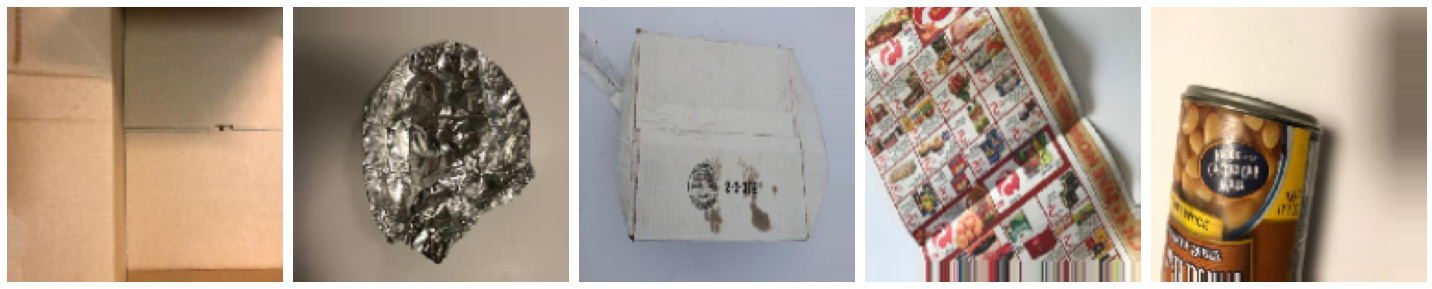

In [34]:
## Show Sample Image (additional)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

In [35]:
## Transfer Learning NASNetMobile
# Download weight of NASNETMobile
#!wget https://storage.googleapis.com/tensorflow/keras-applications/nasnet/NASNet-mobile-no-top.h5

In [36]:
# Config
input_shape = (img_width, img_height, 3)
nasnet_mobile_weight = 'NASNet-mobile-no-top.h5'

# Freezing Layer
pre_trained_model = tf.keras.applications.NASNetMobile(weights = None, include_top=False, input_shape = input_shape)
pre_trained_model.load_weights(nasnet_mobile_weight)
for layer in pre_trained_model.layers:
    layer.trainable = False
pre_trained_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 74, 74, 32)   128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 74, 74, 32)   0           stem_bn1[0][0]                   
_____________________________________________________________________________________________

In [46]:
## Get Last Layer shape
last_layer_name = pre_trained_model.get_output_at(-1).name.split('/')[0]
last_layer = pre_trained_model.get_layer(last_layer_name)
last_output = last_layer.output
print('last layer output shape: ', last_layer.output_shape)

last layer output shape:  (None, 5, 5, 1056)


In [47]:
## Add top layer
x = Flatten()(last_output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense  (len(labels), activation='softmax')(x)
model = Model( pre_trained_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 74, 74, 32)   128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 74, 74, 32)   0           stem_bn1[0][0]                   
____________________________________________________________________________________________

In [48]:
# Save The Best Model
filename = './'
tf.keras.callbacks.ModelCheckpoint(
    filename, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

In [49]:
epochs = 20

# Train process
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=len(train_data_gen),
    epochs=epochs,
    validation_data=test_data_gen,
    validation_steps=len(test_data_gen),
)

Epoch 1/20
72/72 [==============================] - 28s 387ms/step - loss: 1.3472 - accuracy: 0.5835 - val_loss: 0.7607 - val_accuracy: 0.7171

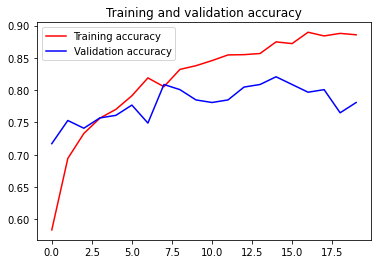

<Figure size 432x288 with 0 Axes>

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()





In [51]:
model.save('NASNETM_garbage.h5')